<a href="https://www.kaggle.com/code/siddp6/live-internet-browsing-using-llm?scriptVersionId=219122794" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Notebook Overview 🚀

## What it Solves 🧩:
This notebook demonstrates an intelligent agent system that answers user queries by combining internal knowledge and live web data. It efficiently handles queries that need up-to-date information from the internet.

## How it Works 🔧:
- **LangChain** powers the AI with GPT to generate responses.
- **Tavily API** fetches relevant URLs when the agent needs to pull in live information.
- **LangGraph** manages the flow, deciding when to answer directly and when to use the web.

### Key Components:
1. **get_urls**: Uses Tavily API to fetch relevant URLs.
2. **convert_html_to_markdown**: Converts HTML content into markdown format.
3. **Flow**: The agent first tries to answer directly, then pulls information from the web when needed.

## Flow Diagram 🔄:

### 1. **General Agent Node**:
   - The first step is to process the user query.
   - If the agent has enough knowledge, it answers the query directly.
   - If it needs more information, it sends the query to the **Internet Agent** node.

### 2. **Internet Agent Node**:
   - This node fetches relevant URLs based on the query using the **get_urls** tool (via Tavily).
   - It then converts the HTML content of those URLs into markdown format using the **convert_html_to_markdown** tool.
   - After retrieving and converting the data, it sends this information back to the **General Agent** node.

### 3. **Combining Responses**:
   - The **General Agent** then combines the answer from its internal knowledge and the markdown content from the internet.
   - It provides a complete, concise response to the user.

## Example 🌐:
The notebook processes a query like "What is square root of 25? and What is apple stock health on 22 Jan 2025?"—answering the math question directly and fetching the latest stock info from the web.

## Conclusion 💡:
This system seamlessly combines pre-existing knowledge with real-time data, providing accurate answers by pulling from both internal and web sources.

## Resources 📚:
- [LangGraph Tutorial - Introduction](https://langchain-ai.github.io/langgraph/tutorials/introduction/#requirements)
- [LangGraph Tutorial - Multi-Agent Supervisor](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/)
- [Tavily API Python SDK - Search API Reference](https://docs.tavily.com/docs/python-sdk/tavily-search/api-reference)

In [1]:
!pip install -U langchain langchain_openai markdownify langgraph tavily-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.0/147.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.2/412.2 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.7/332.7 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 456.1/456.1 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.0/345.0 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.0/378.0 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found exist

In [2]:
# Standard Library Imports
import requests
from typing import Literal

# Third-party Imports
from IPython.display import Image, display
from bs4 import BeautifulSoup
import markdownify

# Kaggle & Tavily Imports
from kaggle_secrets import UserSecretsClient
from tavily import TavilyClient

# LangChain & LangGraph Imports
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.types import Command
from langgraph.graph import END, MessagesState, StateGraph, START

In [3]:
# Secrets and Keys

user_secrets = UserSecretsClient()
OPENAI_API_KEY = user_secrets.get_secret("OPENAI_API_KEY")
TVLY_API_KEY = user_secrets.get_secret("TVLY_API_KEY")

In [4]:
# Utilities

llm = ChatOpenAI(model="gpt-4o-mini", api_key=OPENAI_API_KEY)

def print_stream(stream):
    """
    Prints the messages from a stream object in a user-friendly format.

    Args:
        stream (iterable): The stream of messages to print.
    """
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [5]:
# Tools

@tool
def get_urls(query, topic):
    """
    Fetches a list of URLs based on the provided query and topic using the Tavily API.

    Args:
        query (str): The search query to find relevant URLs.
        topic (str): The specific topic to narrow down the search results.

    Returns:
        list: A list of URLs (strings) from the search results.
    """
    client = TavilyClient(api_key=TVLY_API_KEY)
    response = client.search(query, search_depth="advanced", max_results=15, days=7, topic=topic)

    return [tvly_result["url"] for tvly_result in response["results"]]


@tool
def convert_html_to_markdown(urls):
    """
    Converts HTML content from a list of URLs to markdown format.

    Args:
        urls (list): A list of URLs (strings) to fetch and convert HTML content.

    Returns:
        str: A single concatenated string containing markdown-formatted content 
             from all the provided URLs.
    """
    content = ""
    for url in urls:
        response = requests.get(url)

        soup = BeautifulSoup(response.text, 'html.parser')

        html_content = soup.prettify()
        content = content + markdownify.markdownify(html_content, heading_style="ATX")
        
    return content

In [6]:
# Nodes


# General agent prompt defines the responsibilities and logic flow of the agent working with the "internet_agent."
general_agent_prompt = """
    You are a user assistance agent working with a co-worker named "internet_agent." 
    Your role is to help answer user queries in the following manner:

    1. **Direct Response**: If the entire query can be answered with the information you already have, provide a direct response to the user.
    2. **Internet Request**: If the query requires information from the internet, ask "internet_agent" to gather the necessary details.
    3. **Partial Response**: If part of the query can be answered with your own knowledge, but another part requires input from "internet_agent," only request information from "internet_agent" for the parts you cannot answer.

    Once you receive the response from "internet_agent," combine it with your own knowledge to provide a complete answer to the user.

    **Important**:
    - Call "internet_agent" only when necessary.
    - Your final response should address the full query, combining both your knowledge and the internet information gathered by "internet_agent."
"""




def general_node(
    state: MessagesState, 
) -> Command[Literal["internet_agent", "__end__"]]:
    """
    General node function interacts with the system to determine if the query can be answered with
    existing knowledge or requires information from the internet. If necessary, it will invoke the
    internet agent to gather additional information.
    
    Parameters:
    - state (MessagesState): The current state of messages being processed.
    
    Returns:
    - Command: A command object containing the updated state and the next action to take. 
      It either sends the flow to the "internet_agent" or ends the process.
    """
    
    # Prepare the messages with the system prompt and the user's query.
    messages = [{"role": "system", "content": general_agent_prompt}] + state["messages"]
    
    # Invoke the LLM (Large Language Model) to generate a response based on the user's query.
    response = llm.invoke(messages)
    
    # Determine if the response indicates the need for "internet_agent". If it does, proceed to "internet_agent".
    # Otherwise, end the process.
    goto = "internet_agent" if "internet_agent" in response.content else END
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=response.content, name="general_agent")
            ]
        },
        goto=goto,
    )



internet_agent = create_react_agent(
    llm,
    tools=[convert_html_to_markdown, get_urls],
    state_modifier="""
    You are an assistant designed to help users retrieve and process information from URLs. 
    Follow these steps to complete your task:

    1. **Receive User Query**: Start by receiving a query from the user.
    2. **Determine the Topic**: Decide the appropriate topic for the `get_urls` tool based on the query:
       - For queries related to dates, events, or time-sensitive information, use the "news" topic.
       - For all other queries, use the "general" topic.
    3. **Retrieve URLs**: Use the `get_urls` tool to fetch relevant URLs for the query.
       - Input to `get_urls`: 
         - `query`: The user's search query.
         - `topic`: Either "news" or "general" (based on the previous step).
       - Output from `get_urls`: A list of URLs relevant to the query and topic.
    4. **Convert URLs to Markdown**: Pass the URLs to the `convert_html_to_markdown` tool to get the content in Markdown format.
       - Input to `convert_html_to_markdown`: A list of URLs.
       - Output from `convert_html_to_markdown`: The Markdown-formatted content of the URLs.
    5. **Provide Response**: Use the Markdown content as context to provide a detailed and accurate response to the user.
    6. **Return URLs**: Also return the list of URLs for the user’s reference.

    Ensure your responses are clear, concise, and focused on the user’s query.
    """
)



def internet_node(state: MessagesState) -> Command[Literal["general_agent"]]:
    """
    The internet node function invokes the internet agent to retrieve information from the web 
    based on the current state and user's query. Once the information is retrieved, it updates 
    the state with the new messages and returns control to the general agent to process and 
    combine the final response.

    Parameters:
    - state (MessagesState): The current state of messages being processed.
    
    Returns:
    - Command: A command object containing the updated state and the next action to take.
      The flow returns to the "general_agent" node for further processing.
    """
    
    # Invoke the internet agent with the current state of the query and context.
    result = internet_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="internet_agent")
            ]
        },
        goto="general_agent",
    )

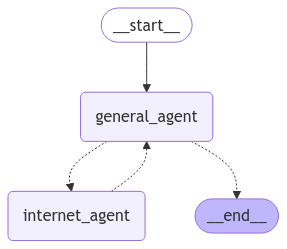

In [7]:
# Flow

# Initialize the workflow state graph
workflow = StateGraph(MessagesState)

# Add nodes to the workflow
workflow.add_node("general_agent", general_node)  
workflow.add_node("internet_agent", internet_node)  
workflow.add_edge(START, "general_agent")

graph = workflow.compile()

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Failed to render the graph visualization: {e}")

In [8]:
# Main


query = "What is square root of 25? and What is apple stock health on 22 Jan 2025"

inputs = {"messages": [("user", query)]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

What is square root of 25? and What is apple stock health on 22 Jan 2025
================================ Human Message =================================
Name: general_agent

The square root of 25 is 5.

As for the health of Apple stock on January 22, 2025, I will need to ask internet_agent for the latest details. Please hold on a moment. 

(integration with internet_agent to gather information about Apple stock health on January 22, 2025)
================================ Human Message =================================
Name: internet_agent

The square root of 25 is **5**.

Regarding the health of Apple stock on January 22, 2025, here are some key points:

1. **Market Performance**: On that day, U.S. technology stocks, including Apple, had mixed performance amidst rising Treasury yields. The S&P 500 rose 0.6%, and important tech stocks were contributing positively to market gains.

2. **Apple Stock Dynamic